### Import Dataset
- Reads the dataset `game_statistics.csv` into a pandas DataFrame for analysis.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#CONSTS
READ_FOLDER_PATH = '../data/processed/'
WRITE_FOLDER_PATH = '../data/processed/'

data = pd.read_csv(READ_FOLDER_PATH+'game_statistics.csv')

print(data.shape[0])
pd.set_option("display.max_colwidth", None) 

941009


### Process Game Data
- Groups match event data by game ID to get aggregated stats, including before the 80th minute, at full time, and in rolling windows (70-75, 75-80, 80-85 minutes).
- **Target variable** = whether a corner was won after 80 minutes

In [2]:
def process_game_data(df):
    games = [] 
 
    # Group by game ID
    for game_id, game_data in df.groupby('id_odsp'):
        #Sort events by time
        game_data = game_data.sort_values(by='time')  

        #Get metadata
        id_odsp = game_id
        date = game_data['date'].iloc[0]
        season =game_data['season'].iloc[0] 
        league = game_data['league'].iloc[0]
        country= game_data['country'].iloc[0]
        home_team = game_data['ht'].iloc[0]
        away_team = game_data['at'].iloc[0]
        odd_h =game_data['odd_h'].iloc[0] 
        odd_d =game_data['odd_d'].iloc[0] 
        odd_a =game_data['odd_a'].iloc[0]

        #Split data at 80 mins
        pre_80_data = game_data[game_data['time'] <= 80]

        # Get score at 80 minutes
        score_pre_80 = pre_80_data['score'].iloc[-1]
        home_score_pre_80, away_score_pre_80 = map(int, score_pre_80.split('-'))
        # Get full-time score
        score_ft = game_data['score'].iloc[-1]

        # Calculate goal difference at 80 minutes
        goal_diff_80 = home_score_pre_80 - away_score_pre_80

        # Determine game state at 80 minutes
        if home_score_pre_80 > away_score_pre_80:
            game_state_80 = 'h'
        elif home_score_pre_80 < away_score_pre_80:
            game_state_80 = 'a'
        else:
            game_state_80 = 'd'  

        #Pre-80 stats
        stats_pre_80 = {
            'home_shots_pre80': pre_80_data['home_shots'].iloc[-1], 
            'away_shots_pre80':pre_80_data['away_shots'].iloc[-1],
            'home_shots_on_target_pre80': pre_80_data['home_shots_on_target'].iloc[-1], 
            'away_shots_on_target_pre80': pre_80_data['away_shots_on_target'].iloc[-1],
            'home_shots_off_target_pre80':pre_80_data['home_shots_off_target'].iloc[-1],
            'away_shots_off_target_pre80': pre_80_data['away_shots_off_target'].iloc[-1],
            'home_yellow_cards_pre80': pre_80_data['home_yellow_cards'].iloc[-1],
            'away_yellow_cards_pre80':pre_80_data['away_yellow_cards'].iloc[-1], 
            'home_sending_off_pre80': pre_80_data['home_sending_off'].iloc[-1],
            'away_sending_off_pre80': pre_80_data['away_sending_off'].iloc[-1],
            'home_fouls_pre80':pre_80_data['home_fouls'].iloc[-1],
            'away_fouls_pre80': pre_80_data['away_fouls'].iloc[-1],
            'home_corners_pre80': pre_80_data['home_corners'].iloc[-1], 
            'away_corners_pre80': pre_80_data['away_corners'].iloc[-1],
        }

        #Full-time stats
        stats_ft = {  
            'home_shots_ft': game_data['home_shots'].iloc[-1], 
            'away_shots_ft':game_data['away_shots'].iloc[-1], 
            'home_shots_on_target_ft': game_data['home_shots_on_target'].iloc[-1], 
            'away_shots_on_target_ft': game_data['away_shots_on_target'].iloc[-1],
            'home_shots_off_target_ft': game_data['home_shots_off_target'].iloc[-1],
            'away_shots_off_target_ft': game_data['away_shots_off_target'].iloc[-1],
            'home_yellow_cards_ft':game_data['home_yellow_cards'].iloc[-1], 
            'away_yellow_cards_ft': game_data['away_yellow_cards'].iloc[-1],
            'home_sending_off_ft': game_data['home_sending_off'].iloc[-1],
            'away_sending_off_ft':game_data['away_sending_off'].iloc[-1],
            'home_fouls_ft': game_data['home_fouls'].iloc[-1],
            'away_fouls_ft': game_data['away_fouls'].iloc[-1],
            'home_corners_ft': game_data['home_corners'].iloc[-1], 
            'away_corners_ft':game_data['away_corners'].iloc[-1],
        }

        #Rolling windows for 70-75, 75-80, and 80-85
        windows = { 
            '70_75': game_data[(game_data['time'] >= 70) & (game_data['time'] < 75)],
            '75_80': game_data[(game_data['time'] >= 75) & (game_data['time'] < 80)], 
            '80_85': game_data[(game_data['time'] >= 80) & (game_data['time'] < 85)],
        }
        window_stats = {}
        stats_columns = ['home_shots', 'away_shots', 'home_shots_on_target', 'away_shots_on_target',
                         'home_shots_off_target', 'away_shots_off_target', 'home_yellow_cards', 'away_yellow_cards',
                         'home_sending_off', 'away_sending_off', 'home_fouls', 'away_fouls',
                         'home_corners', 'away_corners']
        
        for window_name, window_data in windows.items():
            for stat in stats_columns:
                stat_change = (window_data[stat].iloc[-1] - window_data[stat].iloc[0]) if len(window_data) > 1 else 0
                window_stats[f'{stat}_{window_name}'] = stat_change


        #Corner difference (80 to FT)
        corner_diff = {
            'home_corner_diff': stats_ft['home_corners_ft'] -stats_pre_80['home_corners_pre80'], 
            'away_corner_diff': stats_ft['away_corners_ft'] -stats_pre_80['away_corners_pre80'], 
        }

        # Target: Did either team get a corner after 80?
        target = int((corner_diff['home_corner_diff'] > 0) or (corner_diff['away_corner_diff'] > 0))
   
        # Append processed data
        games.append({
            'id_odsp': id_odsp,
            'date': date, 
            'season': season,
            'league':league,
            'country': country, 
            'home_team': home_team,
            'away_team': away_team,
            'odd_h': odd_h,
            'odd_d': odd_d, 
            'odd_a': odd_a,
            'score_pre_80':score_pre_80,
            'score_ft': score_ft,
            'game_state_80': game_state_80,
            'goal_diff_80':goal_diff_80,
            **stats_pre_80, 
            **stats_ft,
            **window_stats,
            **corner_diff,
            'target': target 
        }) 

    # Convert to DataFrame
    return pd.DataFrame(games)

# Load dataset and process
aggregated_data = process_game_data(data)

# Sort and reset index for clean output
aggregated_data = aggregated_data.sort_values(by=['date', 'id_odsp']).reset_index(drop=True)
aggregated_data

,id_odsp,date,season,league,country,home_team,away_team,odd_h,odd_d,odd_a,...,away_yellow_cards_80_85,home_sending_off_80_85,away_sending_off_80_85,home_fouls_80_85,away_fouls_80_85,home_corners_80_85,away_corners_80_85,home_corner_diff,away_corner_diff,target
0,UFot0hit/,2011-08-05,2012,D1,germany,Borussia Dortmund,Hamburg SV,1.56,4.41,7.42,...,0,0,0,1,2,0,0,0,1,1
1,Aw5DflLH/,2011-08-06,2012,D1,germany,FC Augsburg,SC Freiburg,2.36,3.60,3.40,...,0,0,0,1,1,1,0,1,1,1
2,CzPV312a/,2011-08-06,2012,F1,france,Paris Saint-Germain,Lorient,1.55,4.50,9.40,...,0,0,0,0,1,2,0,3,1,1
3,GUOdmtII/,2011-08-06,2012,F1,france,Caen,Valenciennes,2.50,3.40,3.45,...,0,0,0,1,1,0,0,1,3,1
4,M7PhlM2C/,2011-08-06,2012,F1,france,Brest,Evian Thonon Gaillard,2.29,3.25,3.85,...,0,0,0,0,0,2,0,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9069,vJy048Er/,2017-01-22,2017,I1,italy,Empoli,Udinese,2.90,3.18,2.96,...,0,0,0,0,0,0,0,1,0,1
9070,xAkY8l6R/,2017-01-22,2017,I1,italy,Genoa,Crotone,1.97,4.35,8.00,...,0,0,0,1,1,0,0,2,0,1
9071,xSU9scI9/,2017-01-22,2017,E0,england,Chelsea,Hull,1.19,8.50,20.00,...,0,0,0,0,0,1,0,1,0,1
9072,xY7uZwOI/,2017-01-22,2017,F1,france,AS Monaco,Lorient,1.32,6.24,11.50,...,0,0,0,0,1,0,0,0,0,0


### Save Processed Data
- Saves the processed dataset with all statistics to `proccessed_game_data.csv`.  
- A snippet of the first 500 rows is saved as `proccessed_game_data_snippet.csv`.  

In [3]:
print(aggregated_data.shape[0])

aggregated_data.to_csv(WRITE_FOLDER_PATH+'aggregated_data.csv', index=False)
aggregated_data.tail(500).to_csv(WRITE_FOLDER_PATH+'snippets/aggregated_data_snippet.csv', index=False)

9074


### Calculate Stats
Calculates:
- Num of 0s and 1s
- Probabilitiy of 0 and 1 
- Expected Value
- Variance
- Odds (Probability of success / Probability of failure)

In [4]:
# Calculate probabilities and statistics
target_counts=aggregated_data['target'].value_counts()
total_games =target_counts.sum() 
total_1s = target_counts.get(1, 0)
total_0s = target_counts.get(0, 0) 

#Calculate probabilities
prob_corner = target_counts.get(1, 0) / total_games  #Probability of getting a corner
prob_no_corner = target_counts.get(0, 0) / total_games  #Probability of not getting a corner

# Expected value
expected_value = 1*prob_corner + 0*prob_no_corner
#Variance
variance = prob_corner *prob_no_corner  
 
# Odds (Probability of success / Probability of failure)
odds = prob_corner / prob_no_corner if prob_no_corner >0 else float('inf') 
# Decimal betting odds (inverse of probability)
betting_odds = 1 /prob_corner if prob_corner >0 else float('inf') 
    
# Display the results
print("--- Stats ---")
print(f"Total Games: {total_games}") 
print(f"Total 1s: {total_1s}") 
print(f"Total 0s: {total_0s}\n") 
print(f"Probability of getting a corner (P(target=1)): {prob_corner:.4f}")
print(f"Probability of not getting a corner (P(target=0)): {prob_no_corner:.4f}")
print(f"Expected Value:{expected_value:.4f}") 
print(f"Variance: {variance:.4f}\n")
print(f"Odds (Corner vs No Corner): {odds:.4f}") 
print(f"Betting Odds (Decimal): {betting_odds:.2f}") 

--- Stats ---
Total Games: 9074
Total 1s: 6898
Total 0s: 2176

Probability of getting a corner (P(target=1)): 0.7602
Probability of not getting a corner (P(target=0)): 0.2398
Expected Value:0.7602
Variance: 0.1823

Odds (Corner vs No Corner): 3.1700
Betting Odds (Decimal): 1.32


### Plot Number of Games where Target was 1 vs 0

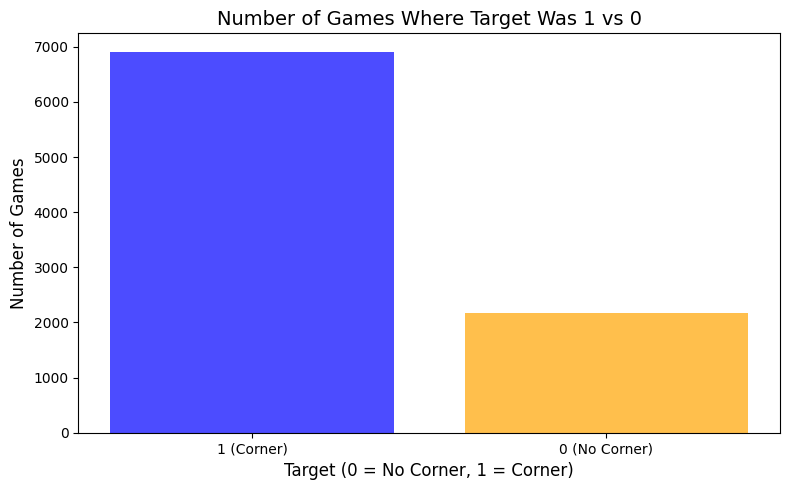

In [5]:
# Plot the number of games where the target was 1 vs 0
target_counts = aggregated_data['target'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 5))
plt.bar(target_counts.index.astype(str), target_counts.values, color=['blue', 'orange'], alpha=0.7)
plt.title('Number of Games Where Target Was 1 vs 0', fontsize=14)
plt.xlabel('Target (0 = No Corner, 1 = Corner)', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.xticks([1, 0], labels=['0 (No Corner)', '1 (Corner)'])
plt.tight_layout()
plt.show()

### Plot corner at 80 minutes: trailing vs winning
- Filters games where the abs goal difference at 80 minutes is 1 and shows percente of trailing or winning team receiving a corner.

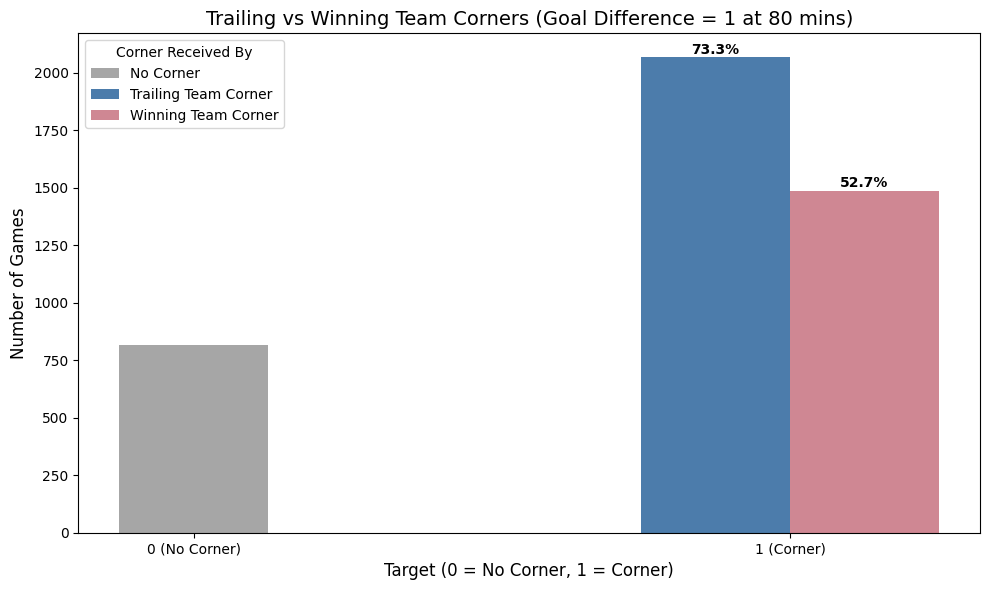

In [6]:
aggregated_data['abs_goal_diff_80'] = aggregated_data['goal_diff_80'].abs()

#Only look at games where goal diff = 1 at 80 mins
filtered_data = aggregated_data[aggregated_data['abs_goal_diff_80'] == 1] 
target_counts = filtered_data['target'].value_counts()
corner_games = filtered_data[filtered_data['target'] == 1].copy()

def flag_corners(row):
    home_corner, away_corner = row['home_corner_diff'] > 0, row['away_corner_diff'] >0
    return {
        'h': {'trailing_team_corner':away_corner,'winning_team_corner':home_corner}, 
        'a': {'trailing_team_corner':home_corner,'winning_team_corner': away_corner}
    }.get(row['game_state_80'], {'trailing_team_corner': False, 'winning_team_corner': False})

corner_games[['trailing_team_corner','winning_team_corner']] =corner_games.apply(flag_corners, axis=1, result_type='expand')

trailing_team_corner_count =corner_games['trailing_team_corner'].sum() 
winning_team_corner_count= corner_games['winning_team_corner'].sum() 
total_corner_games =len(corner_games)
   
plt.figure(figsize=(10, 6))
bar_width = 0.25
 
plt.bar(0, target_counts.get(0, 0), width=bar_width, color='grey', alpha=0.7, label='No Corner') 
trailing_bar = plt.bar(1-bar_width/2, trailing_team_corner_count,width=bar_width, color='#004488', alpha=0.7,label='Trailing Team Corner')
winning_bar = plt.bar(1+bar_width/2,winning_team_corner_count, width=bar_width, color='#BB5566',alpha=0.7,label='Winning Team Corner') 
   
for bar, count in zip([trailing_bar, winning_bar], [trailing_team_corner_count, winning_team_corner_count]):
    percentage = (count / total_corner_games) * 100
    plt.text(bar[0].get_x() + bar[0].get_width() / 2, bar[0].get_height()+1, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Trailing vs Winning Team Corners (Goal Difference = 1 at 80 mins)', fontsize=14)
plt.xlabel('Target (0 = No Corner, 1 = Corner)', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.xticks([0, 1], labels=['0 (No Corner)', '1 (Corner)'])

plt.legend(title='Corner Received By', fontsize=10)
plt.tight_layout()
plt.show()  

### Plot Target by league

- Plots total games played and ratio of Target being 1 vs 0 split across all 5 leagues

target     0     1
country           
england  257  1042
france   537  1539
germany  443  1165
italy    474  1602
spain    465  1550


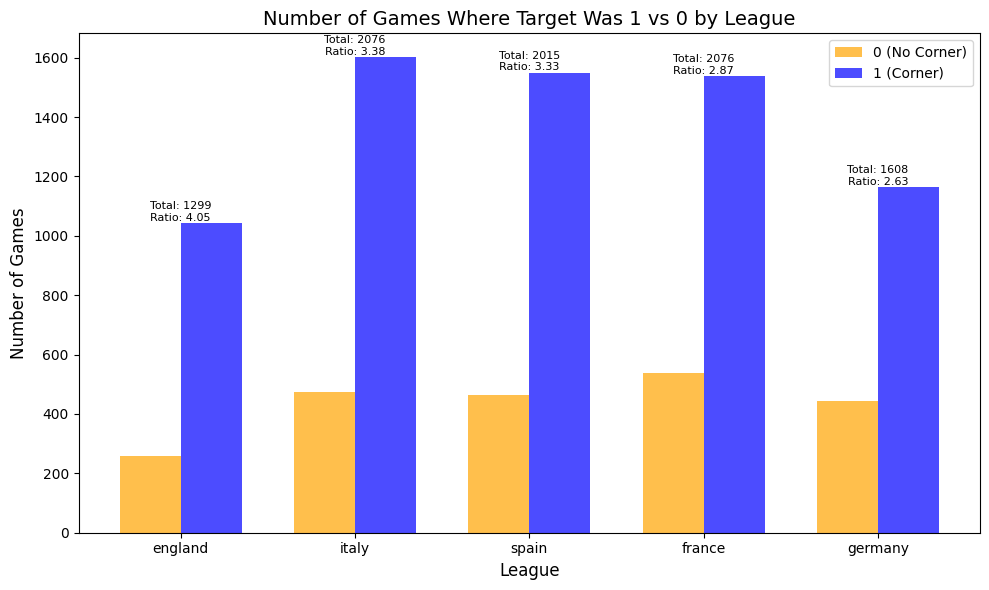

In [7]:
aggregated_data_copy = aggregated_data.copy()
plot_data = aggregated_data_copy.groupby(['country', 'target']).size().unstack(fill_value=0)
print(plot_data)

#Calculate total games and ratio
plot_data['total'] = plot_data[0] + plot_data[1]
plot_data['ratio'] = plot_data[1] /plot_data[0].replace(0,1)

#most 'succesful' league plotted first
plot_data = plot_data.sort_values(by='ratio', ascending=False)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6)) 
bar_width = 0.35 
index = range(len(plot_data)) 
   
bars_0 = ax.bar([i- bar_width/2 for i in index], plot_data[0],bar_width,label='0 (No Corner)', color='orange', alpha=0.7)
bars_1 = ax.bar([i+ bar_width/2 for i in index], plot_data[1],bar_width,label='1 (Corner)', color='blue', alpha=0.7) 

#annotate total game and ratio:
for i, league in enumerate(plot_data.index):
    total_games= plot_data.loc[league, 'total']
    ratio =plot_data.loc[league, 'ratio'] 
    max_height = max(plot_data.loc[league, 0], plot_data.loc[league, 1]) 
    ax.text(i, max_height + 1, f'Total: {total_games}\nRatio: {ratio:.2f}', 
            ha='center',va='bottom',fontsize=8) 

ax.set_title('Number of Games Where Target Was 1 vs 0 by League', fontsize=14)
ax.set_xlabel('League', fontsize=12)
ax.set_ylabel('Number of Games', fontsize=12)
ax.set_xticks(index)
ax.set_xticklabels(plot_data.index)
ax.legend() 
plt.tight_layout()
plt.show() 

### Plot Game State vs Target

- Investigates difference in game state distribution when target is 0 vs 1

game_state_80     a     d     h
target                         
0               566   588  1022
1              1939  1962  2997


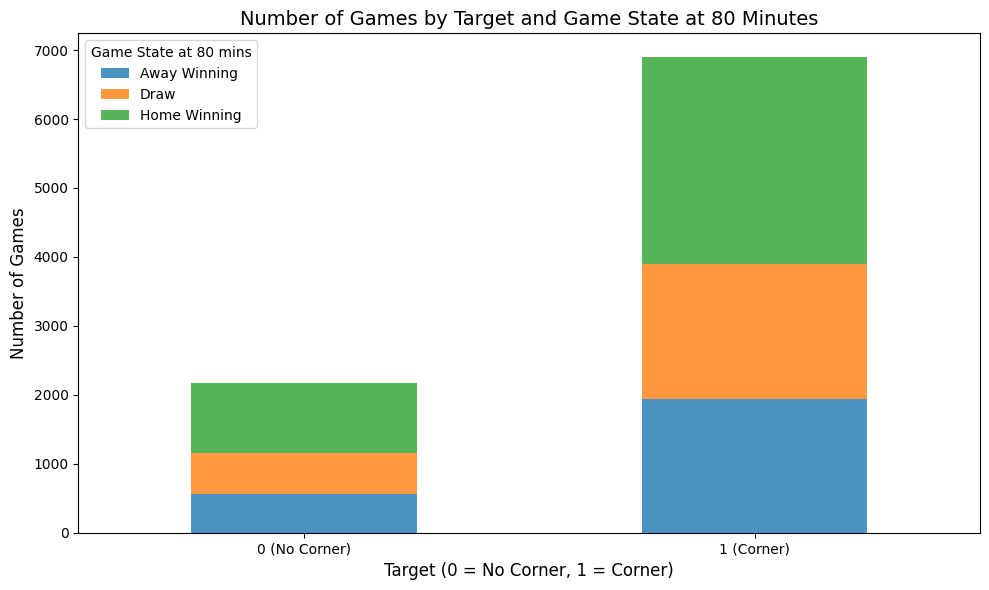

In [8]:
target_game_state_counts = aggregated_data_copy.groupby(['target', 'game_state_80']).size().unstack(fill_value=0)
print(target_game_state_counts)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))
target_game_state_counts.plot(kind='bar', stacked=True, ax=ax, alpha=0.8)

ax.set_title('Number of Games by Target and Game State at 80 Minutes', fontsize=14)
ax.set_xlabel('Target (0 = No Corner, 1 = Corner)', fontsize=12)
ax.set_ylabel('Number of Games', fontsize=12)
ax.set_xticks([0, 1])
ax.set_xticklabels(['0 (No Corner)', '1 (Corner)'],rotation=0)
ax.legend(title='Game State at 80 mins',labels=['Away Winning','Draw','Home Winning'])
plt.tight_layout()
plt.show()